# Activations, Gradients, BatchNorm

Solution to exercises proposed in [1].


**References:**

[1] [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=1715s&ab_channel=AndrejKarpathy)

**Exercises:**

0. *Implement PyTorch like API for MLPs. Implement visualization API (to visualize activation function saturations, gradients and gradient update rates).*

1. *I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.*

2. *BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.*

In [621]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [622]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-12-01 21:17:27--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.009s  

2022-12-01 21:17:27 (24.5 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [623]:
words = open("names.txt", "r").read().splitlines()

In [624]:
chars = sorted(list(set("".join(words))))
stoi = {s:idx + 1 for idx, s in enumerate(chars)}
stoi["."] = 0
itos = {idx: s for s, idx in stoi.items()}
block_size = 3

In [625]:
def build_dataset(words):  
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [626]:
x, y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [ ]:
# compute random indices.
m = len(x)

rand_idxs = torch.randperm(m)
# shuffle the data.
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]


x_train = x_train.to(device="cuda")
y_train = y_train.to(device="cuda")
x_val = x_val.to(device="cuda")
y_val = y_val.to(device="cuda")
x_test = x_test.to(device="cuda")
y_test = y_test.to(device="cuda")

## 0. *Implement PyTorch like API for MLPs. Implement visualization API (to visualize activation function saturations, gradients and gradient update rates).*


**Implement the linear layer**

In [ ]:
class Linear:
    def __init__(self, in_dim, out_dim, bias=True, device="cuda"):
        # Init weights using kaiming approach
        scale = 1 / (in_dim ** (0.5))
        self.w = torch.randn((in_dim, out_dim)) * scale
        self.b = torch.zeros(out_dim) if bias else None

        if device == "cuda":
            self.w = self.w.to(device="cuda")
            if self.b is not None:
                self.b = self.b.to(device="cuda")

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        
        return self.out

    def parameters(self):
        params = [self.w] + ([] if self.b is None else [self.b])
        return params

**Implement the embedding layer**

In [ ]:
class Embedding:
    def __init__(self, in_dim, out_dim, device="cuda"):
        self.c = torch.randn((in_dim, out_dim))

        if device == "cuda":
            self.c = self.c.to(device="cuda")

    def __call__(self, x):
        self.out = self.c[x]
        return self.out

    def parameters(self):
        return [self.c]

**Implement the tanh**

In [ ]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

**Implement the batch norm**

In [ ]:
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5, device="cuda"):
        self.momentum =  momentum
        self.eps = eps
        self.train = True

        # Init the bn_gain and bn_bias
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # Init running average of mean and var (global mean and var)
        # Recall that the global mean and var is used for inference
        self.mean_running = torch.zeros(dim)
        self.var_running = torch.ones(dim)

        if device == "cuda":
            self.gain = self.gain.to(device="cuda")
            self.bias = self.bias.to(device="cuda")
            self.mean_running = self.mean_running.to(device="cuda") 
            self.var_running = self.mean_running.to(device="cuda")

    def __call__(self, x):
        if self.train:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.mean_running
            x_var = self.var_running
        
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gain * x_hat + self.bias

        if self.train:
            self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * x_mean
            self.var_running = (1 - self.momentum) * self.var_running + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gain, self.bias]

**Implement the network**

In [ ]:
n_embed = 10
block_size = 3
n_fc1 = 100
n_fc2 = 100
vocab_size = 27

In [ ]:
class MLP:
    def __init__(self):
        self.layers = [
            # Define the embedding matrix
            Embedding(in_dim=x_train.shape[0],out_dim=n_embed),

            # Linear layer + BatchNorm + Tanh
            Linear(in_dim=n_embed * block_size, out_dim=n_fc1, bias=False),
            BatchNorm1d(dim=n_fc1),
            Tanh(),

            # Linear layer + BatchNorm + Tanh
            Linear(in_dim=n_fc1, out_dim=n_fc2, bias=False),
            BatchNorm1d(dim=n_fc2),
            Tanh(),

            # Linear layer + BatchNorm
            Linear(in_dim=n_fc2, out_dim=vocab_size, bias=False),
            BatchNorm1d(dim=vocab_size),
        ]

        # Set requires_grad to all parameters
        self.apply_grads()

    def __call__(self, x):
        # Apply the embedding
        self.out = self.layers[0](x).view(-1, n_embed * block_size)

        for layer in self.layers[1: ]:
            self.out = layer(self.out)

        return self.out
    
    def parameters(self):
        params = [p for layer in self.layers for p in layer.parameters()]
        return params

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def apply_grads(self):
        for p in self.parameters():
            p.requires_grad = True

In [ ]:
net = MLP()
# print(net.layers[1].w.device)
out = net(x_train)
out.shape

torch.Size([182516, 27])

**Overfit the first batch**

In [ ]:
batch_size = 32
rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

In [ ]:
n_steps = 1000
batch_size = 32
lr = 0.1

model = MLP()
losses = []

for iter in range(n_steps):
    # Forward pass
    y_hat = model(x_batch)
    loss = F.cross_entropy(y_hat, y_batch)
    losses.append(loss.item())

    # Backward pass
    model.zero_grad()
    loss.backward()
    # lr = lr if iter < 150000 else iter / 10

    # Update the weights
    for p in model.parameters():
        p.data = p.data - lr * p.grad

print(f"loss (train): {loss.item()}")

loss (train): 0.054336197674274445


[]

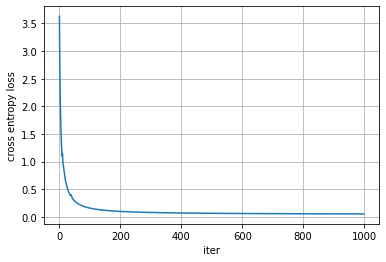

In [ ]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot()

**Implement the training loop**

In [ ]:
from tqdm import tqdm

def train_model(x_train, y_train, model, 
                n_steps=200000, batch_size=32, learn_rate=0.1):
    losses = []
    update_vs_data = []

    for iter in tqdm(range(n_steps)):
        # Sample a random batch
        rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
        x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

        # Forward pass
        y_hat = model(x_batch)
        loss = F.cross_entropy(y_hat, y_batch)
        losses.append(loss.item())

        # Backward pass
        for layer in model.layers:
            layer.out.retain_grad()
        model.zero_grad()
        loss.backward()
        
        # Update the weights
        learn_rate = learn_rate if iter < (3 / 4 * n_steps) else learn_rate / 10
        for p in model.parameters():
            p.data = p.data - learn_rate * p.grad

        with torch.no_grad():
            ud_iter = []
            for p in model.parameters():
                ud = (learn_rate * p.grad).std() / p.data.std()
                ud = ud.log10().item()
                ud_iter.append(ud)

            update_vs_data.append(ud_iter)

    print(f"loss (train): {loss.item()}")

    return losses, update_vs_data

**Implement (debug) visualization**

In [ ]:
def plot_tanh_activations(model):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(model.layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act = layer.out

            sat_perc = ((tanh_act.abs() > 0.97).float().mean() * 100.0).item()
            tanh_act_mean = tanh_act.mean().item()
            tanh_act_std = tanh_act.std().item()
            layer_name = layer.__class__.__name__
            print(f"layer: {layer_name} \t mean: {round(tanh_act_mean, 3)} \t std: {round(tanh_act_std, 3)} \t sat_perc[%]: {round(sat_perc, 3)}")
            cnts, vals = torch.histogram(tanh_act.to(device="cpu"), density=True)
            
            # note: `.detach()` returns a new Tensor, detached from the current graph.
            # which will never require gradient.
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title('distribution of activations for each layer');
    plt.show();


def plot_tanh_grads(model):
    plt.figure(figsize=(12, 4))
    legends = []
    for idx, layer in enumerate(model.layers[: -1]):
        if isinstance(layer, Tanh):
            tanh_act_grad = layer.out.grad

            tanh_act_mean = tanh_act_grad.mean().item()
            tanh_act_std = tanh_act_grad.std().item()
            layer_name = layer.__class__.__name__
            print(f"layer: {layer_name} \t mean: {round(tanh_act_mean, 6)} \t std: {round(tanh_act_std, 6)} \t")
            cnts, vals = torch.histogram(tanh_act_grad.to(device="cpu"), density=True)
            
            # note: `.detach()` returns a new Tensor, detached from the current graph.
            # which will never require gradient.
            plt.plot(vals[:-1].detach(), cnts.detach())
            legends.append(f"layer: {idx} ({layer_name})")

    plt.legend(legends);
    plt.title('distribution of gradients for each layer');
    plt.show();

def plot_update_vs_data(model, update_vs_data):
    plt.figure(figsize=(12, 4))
    legends = []

    for i, p in enumerate(model.parameters()):
        # plot only for weight matrices and not bias terms
        if p.ndim == 2:
            plt.plot([
                update_vs_data[j][i] for j in range(len(update_vs_data))
            ])
            legends.append('param %d' % i)

    # NOTE: these ratios should be ~1e-3, indicate on plot
    plt.plot([0, len(ud)], [-3, -3], 'k')
    plt.legend(legends);
    plt.title(f"Update vs data over all iters")
    plt.show()

In [ ]:
model = MLP()
losses, ud = train_model(x_train, y_train, model, 
                    n_steps=10000, batch_size=32,
                    learn_rate=0.1)

100%|██████████| 10000/10000 [00:39<00:00, 250.60it/s]

loss (train): 2.2621524333953857


In [ ]:
# Check if gradients were retained on the intermediate varibles.
for layer in model.layers:
    print(layer.out.grad is None)

False
False
False
False
False
False
False
False
False


layer: Tanh 	 mean: 0.009 	 std: 0.66 	 sat_perc[%]: 5.969
layer: Tanh 	 mean: 0.012 	 std: 0.684 	 sat_perc[%]: 5.406


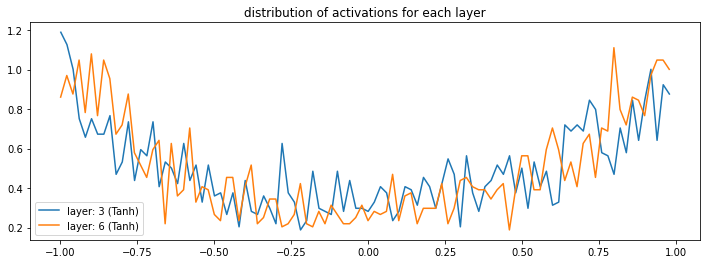

In [ ]:
plot_tanh_activations(model)

layer: Tanh 	 mean: 0.0 	 std: 0.003715 	
layer: Tanh 	 mean: 0.0 	 std: 0.003172 	


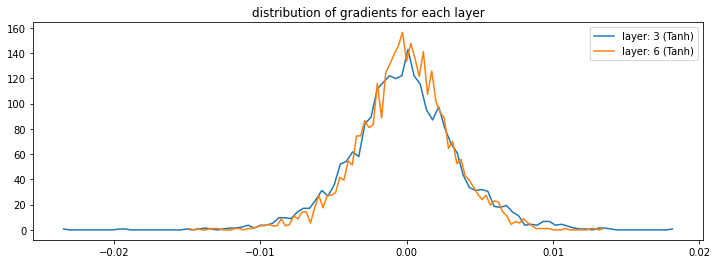

In [ ]:
plot_tanh_grads(model);

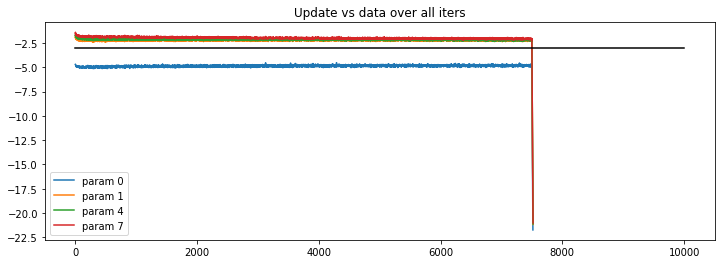

In [ ]:
plot_update_vs_data(model, ud)

In [ ]:
with torch.no_grad():
    y_hat = model(x_val)
    loss = F.cross_entropy(y_hat, y_val)
    print(f"loss (val): {loss}")

loss (val): 2.25907301902771


## 1. *I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.*

**Init weights and biases as a tensor of zeros**

In [ ]:
class Linear:
    def __init__(self, in_dim, out_dim, bias=True, device="cuda"):
        # Init weights using kaiming approach
        scale = 1 / (in_dim ** (0.5))
        self.w = torch.zeros((in_dim, out_dim)) * scale
        self.b = torch.zeros(out_dim) if bias else None

        if device == "cuda":
            self.w = self.w.to(device="cuda")
            if self.b is not None:
                self.b = self.b.to(device="cuda")

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        
        return self.out

    def parameters(self):
        params = [self.w] + ([] if self.b is None else [self.b])
        return params

class Embedding:
    def __init__(self, in_dim, out_dim, device="cuda"):
        self.c = torch.zeros((in_dim, out_dim))

        if device == "cuda":
            self.c = self.c.to(device="cuda")

    def __call__(self, x):
        self.out = self.c[x]
        return self.out

    def parameters(self):
        return [self.c]

**Lets get rig of the train function so we can dig deeper.**

In [ ]:
from tqdm import tqdm
    
n_steps=10
batch_size=32
learn_rate=0.1
#################################
model_zero = MLP()
grads = []
#################################

losses = []
update_vs_data = []

for iter in tqdm(range(n_steps)):
    # Sample a random batch
    rand_idx = torch.randint(0, x_train.shape[0], (batch_size, ))
    x_batch, y_batch = x_train[rand_idx], y_train[rand_idx]

    # Forward pass
    y_hat = model_zero(x_batch)
    loss = F.cross_entropy(y_hat, y_batch)
    losses.append(loss.item())

    # Backward pass
    for layer in model_zero.layers:
        layer.out.retain_grad()
    model_zero.zero_grad()
    loss.backward()
    
    # Update the weights
    learn_rate = learn_rate if iter < (3 / 4 * n_steps) else learn_rate / 10
    for idx, p in enumerate(model_zero.parameters()):
        p.data = p.data - learn_rate * p.grad
        if iter == 5:
            grads.append((p.grad, idx))

    with torch.no_grad():
        ud_iter = []
        for p in model_zero.parameters():
            ud = (learn_rate * p.grad).std() / p.data.std()
            ud = ud.log10().item()
            ud_iter.append(ud)

        update_vs_data.append(ud_iter)

print(f"loss (train): {loss.item()}")

100%|██████████| 10/10 [00:00<00:00, 105.98it/s]

loss (train): 3.247382402420044


[]

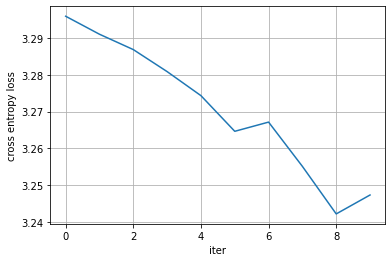

In [ ]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("cross entropy loss")
plt.grid()
plt.plot()

In [ ]:
# Check if gradients were retained on the intermediate varibles.
for layer in model.layers:
    print(layer.out.grad is None)

True
True
True
True
True
True
True
True
True


layer: Tanh 	 mean: 0.0 	 std: 0.0 	 sat_perc[%]: 0.0
layer: Tanh 	 mean: 0.0 	 std: 0.0 	 sat_perc[%]: 0.0


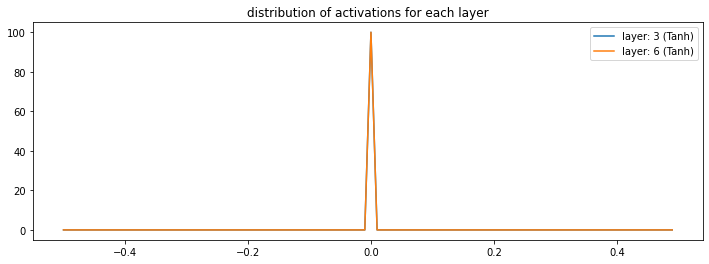

In [ ]:
plot_tanh_activations(model_zero)

layer: Tanh 	 mean: 0.0 	 std: 0.0 	
layer: Tanh 	 mean: 0.0 	 std: 0.0 	


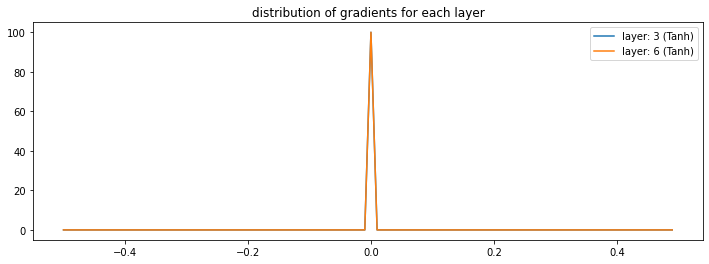

In [ ]:
plot_tanh_grads(model_zero);

**Comment**: we get no training in the first and second. Meaning that gradients get computed at the loss function level, but only a fraction of the gradients is backpropagated to the last layer, where as no gradients are propaget to first and second layer, therefore the network can't learn (well)

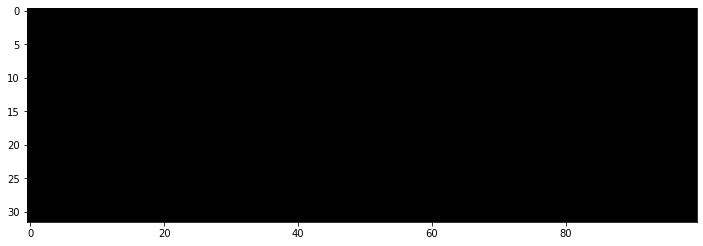

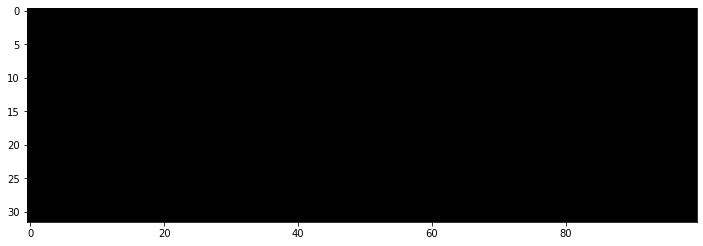

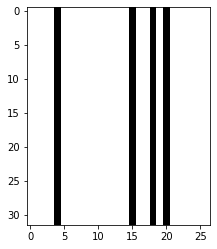

In [ ]:
plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
h = h.to(device="cpu")
h.shape

plt.imshow(h.abs() > 0.01, cmap="gray", interpolation="nearest");


plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h1 = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
w2, b2 = model_zero.layers[4].w, model_zero.layers[5].bias
h2 = torch.tanh(h1 @ w2 + b2)
h2 = h2.to(device="cpu")

plt.imshow(h2.abs() > 0.01, cmap="gray", interpolation="nearest");

plt.figure(figsize=(12, 4))
c = model_zero.layers[0].c
w1, b1 = model_zero.layers[1].w, model_zero.layers[2].bias
h1 = torch.tanh(c[x_batch].view(-1, n_embed * block_size) @ w1 + b1)
w2, b2 = model_zero.layers[4].w, model_zero.layers[5].bias
h2 = torch.tanh(h1 @ w2 + b2)
w3, b3 = model_zero.layers[7].w, model_zero.layers[8].bias
h3 = h2 @ w3 + b3
h3 = h3.to(device="cpu")

plt.imshow(h3.abs() > 0.01, cmap="gray", interpolation="nearest");

We see that after only $10$ we only have one parameter with grad non equal to zero, this is the final batch normalization layer. If we let this network train longer it wouldn't get much better.

In [ ]:
for g in grads:
    if g[0].sum() > 0.0:
        print(f"non zero grad: {g[0]}")
        print(f"param index of non zero grad: {g[1]} / {len(model_zero.parameters())}")

non zero grad: tensor([-0.1482, -0.1167,  0.0364,  0.0367,  0.0056, -0.0868,  0.0364,  0.0364,
         0.0368, -0.0249,  0.0051,  0.0367, -0.0874,  0.0368, -0.1182,  0.0372,
         0.0364,  0.0364,  0.0369,  0.0054,  0.0057,  0.0052,  0.0365,  0.0364,
         0.0364,  0.0064,  0.0368], device='cuda:0')
param index of non zero grad: 9 / 10


**Final comment**: During the forward pass the y_hat vector always sums up to roughly zero, i.e we get no activations, this results in a roughly uniform distributuon of probabilities (this is computed internaly in the cross_entropy function), which gives us some, loss. This small loss is than backprogated through the network (it seems liek some of it updates the weights in the last batch norm layer, but the reast of the weights of the network seem to stay at zero, therefore we get no activation elsewhere), but doesn't change the weights enough.

## 2. *BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.*

**Init the old layers**

In [627]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # Init weights and apply Kaiming initialization
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** (0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Init params trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Init global params (running average params)
        # called "buffers" in PyTorch
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            # note that this time we are using var = std^2
            x_var = self.running_var 

        # Normalize the pre-activations
        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # Update the running mean and var
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

**This time we won't work with the MLP class, since we wan't to have low level access to variables**

In [628]:
# compute random indices.
m = len(x)

rand_idxs = torch.randperm(m)
# shuffle the data.
x = x[rand_idxs]
y = y[rand_idxs]
n1 = int(0.8 * m)
n2 = int(0.9 * m)

x_train = x[:n1]
y_train = y[:n1]
x_val = x[n1:n2]
y_val = y[n1:n2]
x_test = x[n2:]
y_test = y[n2:]


x_train = x_train.to(device="cpu")
y_train = y_train.to(device="cpu")
x_val = x_val.to(device="cpu")
y_val = y_val.to(device="cpu")
x_test = x_test.to(device="cpu")
y_test = y_test.to(device="cpu")

In [629]:
def create_net(weight_gain = 5 / 3):
    n_embed = 10 # the dimensionality of the character embedding vectors
    n_hidden = 100 # the number of neurons in the hidden layer of the MLP
    vocab_size = 27

    g = torch.Generator().manual_seed(2147483647) # for reproducibility
    c = torch.randn((vocab_size, n_embed), generator=g)
    
    # Place batch norm after linear layer and before nonlinearity.
    layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
    ]

    with torch.no_grad():
        # last layer: make less confident
        layers[-1].gamma *= 0.1
        #layers[-1].weight *= 0.1
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 1.0 #5/3

    params = [c] + [p for layer in layers for p in layer.parameters()]
    print(f"num params: {sum(p.nelement() for p in params)}")
    for p in params:
        p.requires_grad = True

    return c, layers, params

In [630]:
c, layers, params = create_net()

num params: 16424


In [631]:
def train_net(c, layer, params):
    # same optimization as last time
    max_steps = 10000
    batch_size = 32
    lossi = []
    ud = []

    for i in tqdm(range(max_steps)):
        # minibatch construct
        ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = x_train[ix], y_train[ix] # batch X,Y

        # forward pass
        emb = c[Xb] # embed the characters into vectors
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
        for p in params:
            p.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
        for p in params:
            p.data += -lr * p.grad

        lossi.append(loss.log10().item())
        with torch.no_grad():
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in params])

    return ud

In [ ]:
train_net(c, layer, params)

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_val, y_val),
    'test': (x_test, y_test),
  }[split]
  emb = c[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.216109275817871
val 2.2396609783172607


**Fold in the batch norm parts**

In order to fold the gamma, beta, running mean and running var into previous weights we should perform the following:

Output of the $i$th linear layer is:

$\hat{y} = w x$

Output of the $i + 1$th batch norm layer is:

$\gamma \frac{\hat{y} - \overline{\hat{y}}}{\sqrt{Var(\hat{y})}} + \beta$,

We can rewrite this equation as follows:

$\gamma \frac{\hat{y}}{\sqrt{Var(\hat{y})}} + ( -\frac{\overline{\hat{y}}}{\sqrt{Var(\hat{y})}} + \beta)$

Now plugging in the $i$th layer weight $w$ we get:

$\gamma \frac{w x}{\sqrt{Var(\hat{y})}} + ( -\frac{\overline{\hat{y}}}{\sqrt{Var(\hat{y})}} + \beta)$

Finally lets explicitly state the weight of the $i$th layer ($w_i$) and the bias of the $i$th layer ($b_i$), by taking into account the parameters of the $i + 1$th batch norm layer:

$w_i = \gamma \frac{w}{\sqrt{Var(\hat{y})}} $

$b_i = -\frac{\overline{\hat{y}}}{\sqrt{Var(\hat{y})}} + \beta$

In [633]:
with torch.no_grad():
    layers[0].weight *= (layers[1].gamma / torch.sqrt(layers[1].running_var))
    layers[3].weight *= (layers[4].gamma / torch.sqrt(layers[4].running_var))
    layers[6].weight *= (layers[7].gamma / torch.sqrt(layers[7].running_var))
    layers[0].bias = - ((layers[1].gamma * layers[1].running_mean) / torch.sqrt(layers[1].running_var)) + layers[1].beta
    layers[3].bias = - ((layers[4].gamma * layers[4].running_mean) / torch.sqrt(layers[4].running_var)) + layers[4].beta
    layers[6].bias = - ((layers[7].gamma * layers[7].running_mean) / torch.sqrt(layers[7].running_var)) + layers[7].beta

In [634]:
new_layers = []

for layer in layers:
    if not isinstance(layer, BatchNorm1d):
        new_layers.append(layer)

for layer in new_layers:
    print(layer.__class__.__name__)

Linear
Tanh
Linear
Tanh
Linear


In [636]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_val, y_val),
    'test': (x_test, y_test),
  }[split]
  emb = c[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for new_layer in new_layers:
    x = new_layer(x)

  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('val')

val 2.2375786304473877


**Comment**: Yeaayy we get the sameresult 😀